<a href="https://colab.research.google.com/github/OrangeSunProgramming/brain-tumor-classification/blob/main/models/augmented_model/augmented_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
#Importing all the libraries necessary for the DNN project
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [47]:
#Getting the training and validation dataset
image_height = 180
image_width = 180
batch_size = 32

dataset_dir = "/content/drive/MyDrive/brain_tumor_classification_dataset/brain_tumor_dataset/brain_tumor_classification/Training"
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir, validation_split=0.2, subset="training", seed=123, image_size=(image_height, image_width), batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir, validation_split=0.2, subset="validation", seed=123, image_size=(image_height, image_width), batch_size=batch_size)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [48]:
class_names = train_ds.class_names
print(f"The classes: {class_names}")

The classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


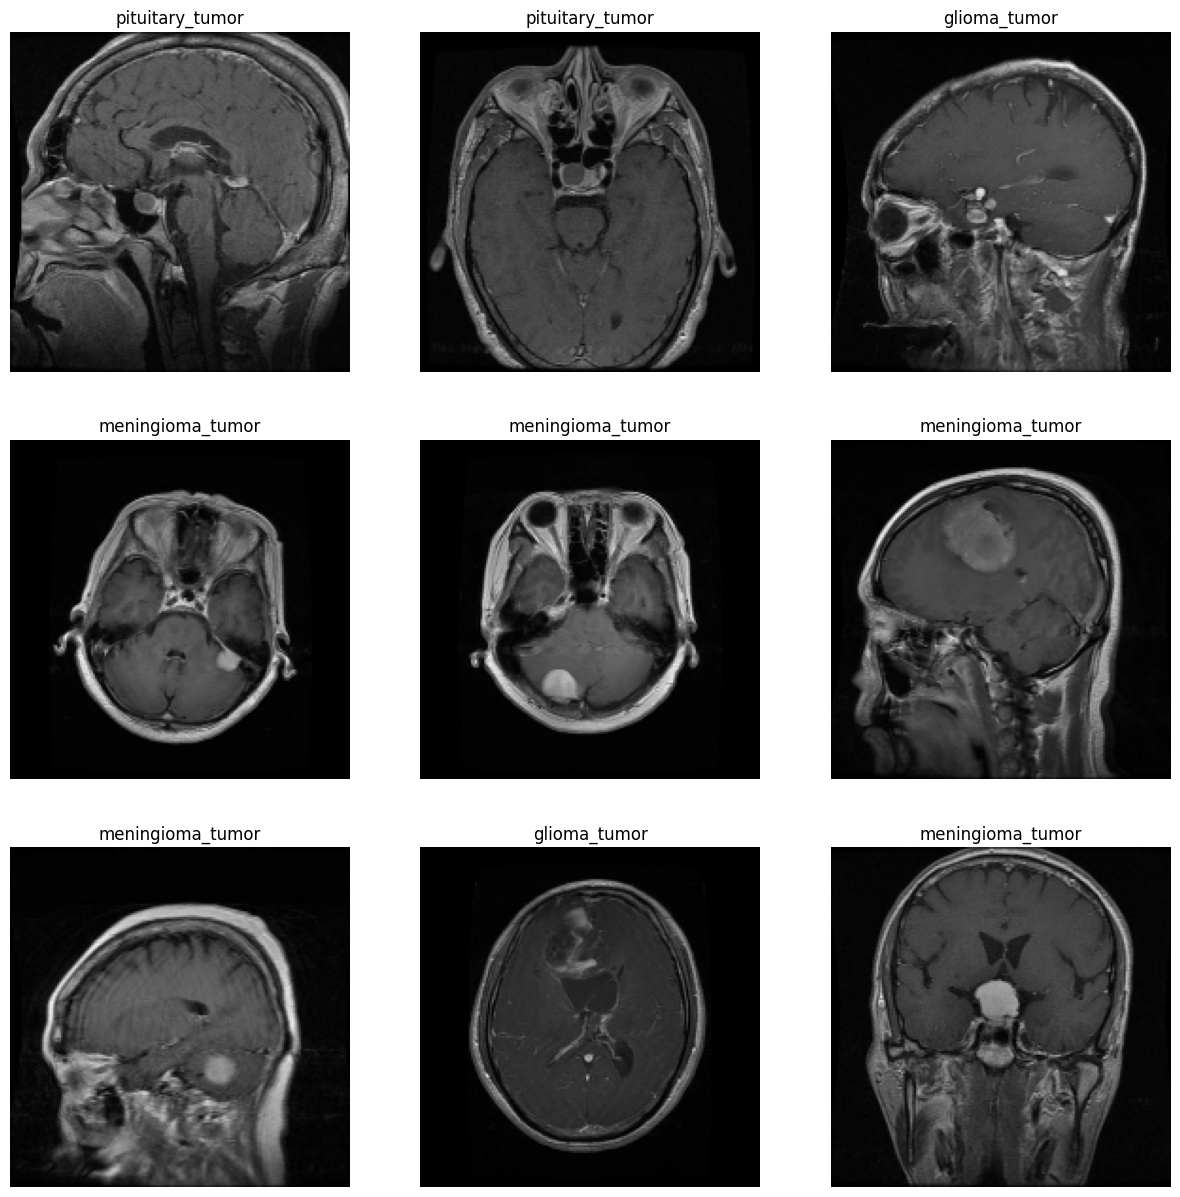

In [49]:
#Visualizing the dataset
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.savefig("/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/dataset images example/brain_tumor_images_examples.png")

In [50]:
for image_batch, labels_batch in train_ds:
  print(f"Image batch shape: {image_batch.shape}")
  print(f"Labels batch shape: {labels_batch.shape}")
  break

Image batch shape: (32, 180, 180, 3)
Labels batch shape: (32,)


In [51]:
#Since we don't want I/O to become blocked then we will yield the data from disk.
#For this we use buffered prefetching

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
#Augmented model (data augmentation implementation)
inputs1 = tf.keras.layers.Input(shape=(image_height, image_width, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs1)
x = tf.keras.layers.RandomFlip("horizontal")(x)
x = tf.keras.layers.RandomRotation(0.1)(x)
x = tf.keras.layers.RandomZoom(0.1)(x)
x = tf.keras.layers.Conv2D(16, 3, activation="relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs1 = tf.keras.layers.Dense(4, activation="softmax")(x)

augmented_model = tf.keras.models.Model(inputs=inputs1, outputs=outputs1)

augmented_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [53]:
augmented_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_3 (RandomFlip)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_3 (RandomZoom)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 59168)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       3,786,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,792,164 (14.47 MB)

 Trainable params: 3,792,164 (14.47 MB)

 Non-trainable params: 0 (0.00 B)

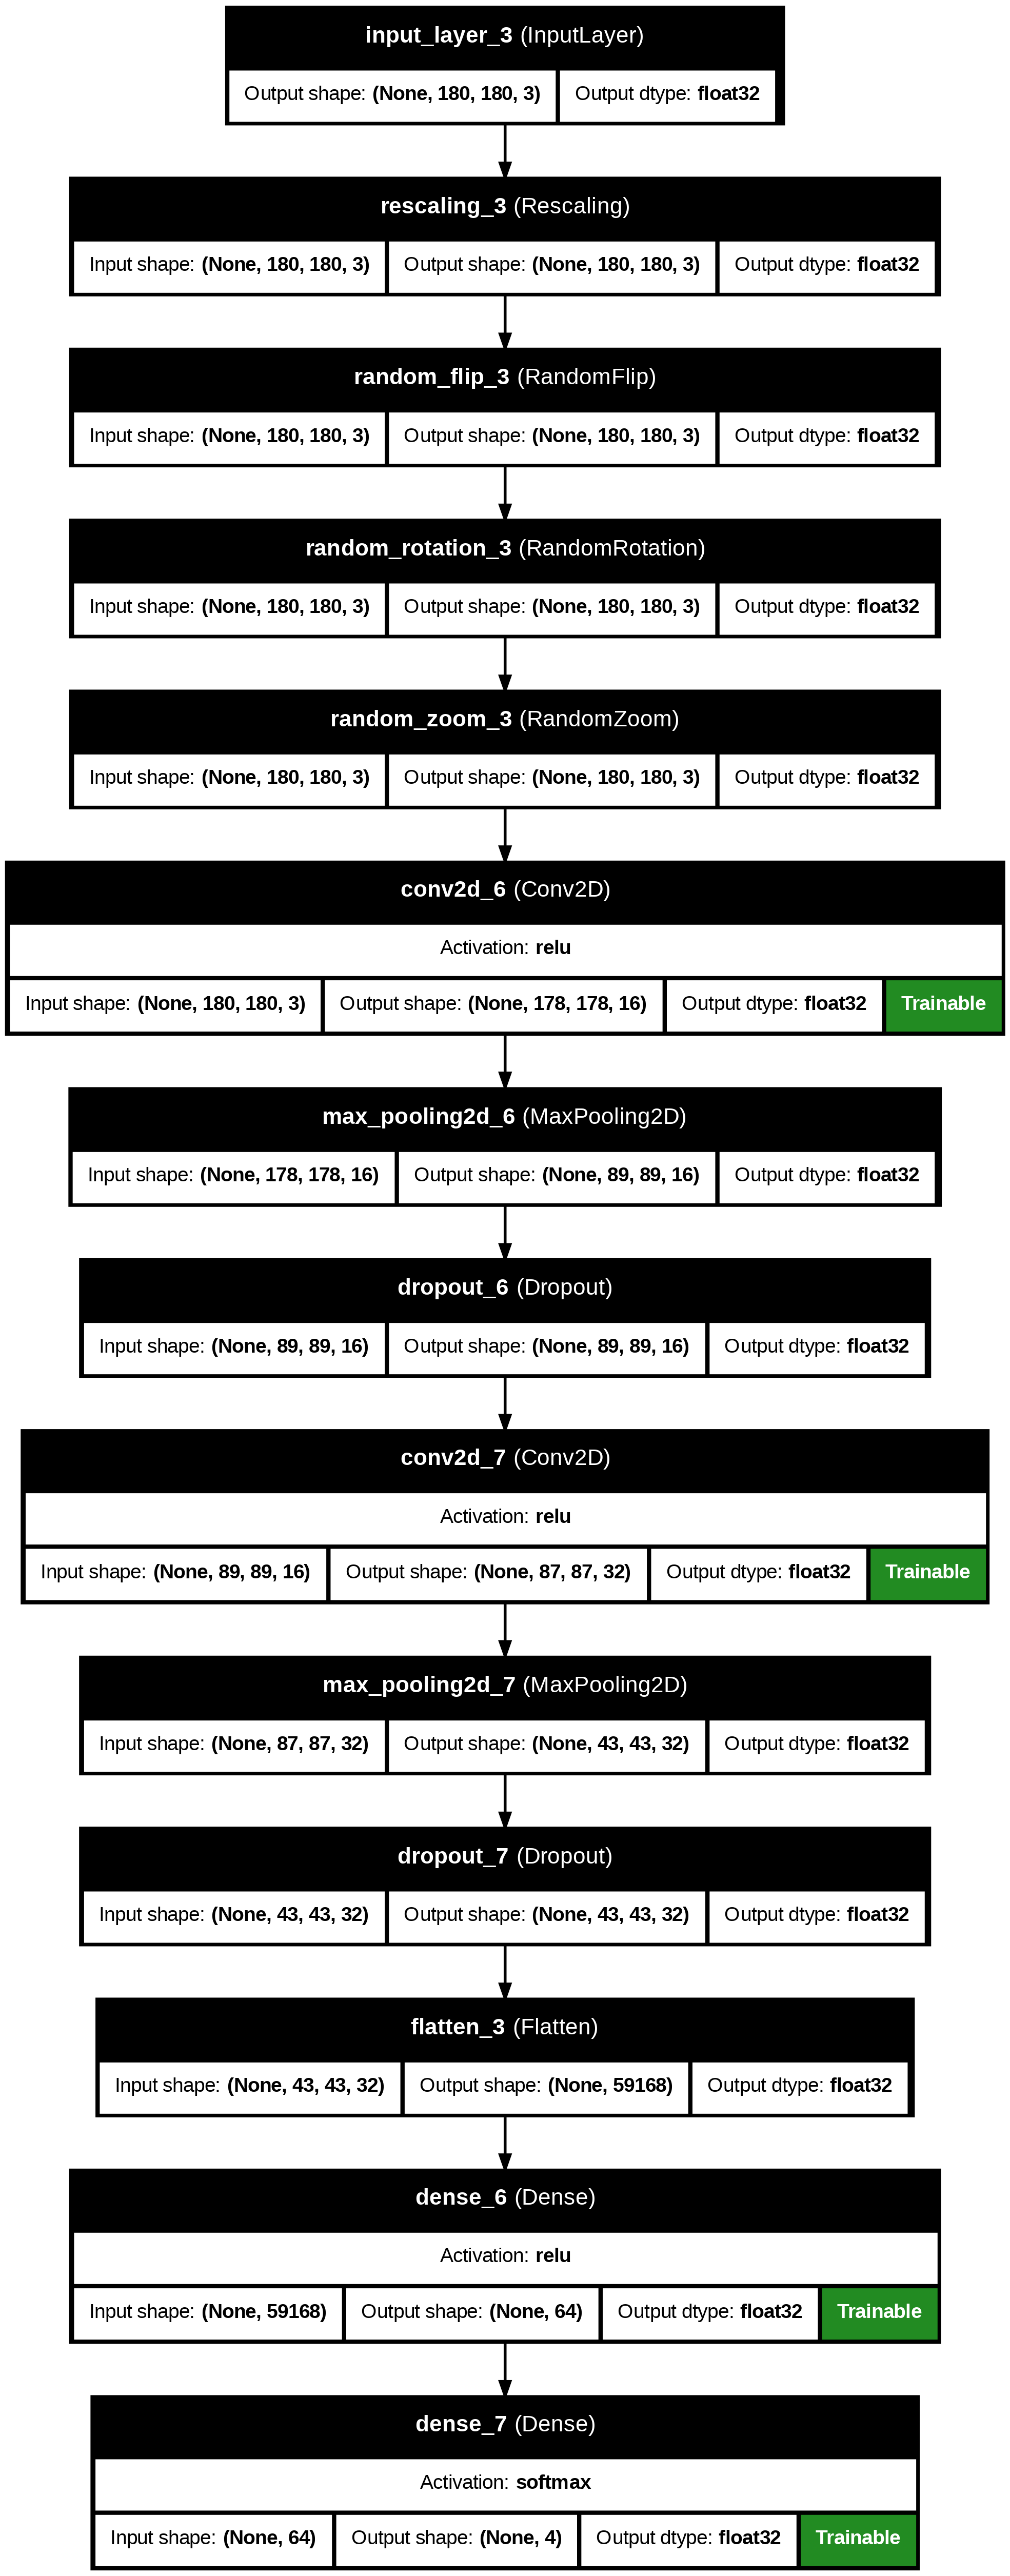

In [54]:
tf.keras.utils.plot_model(augmented_model, to_file = "/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/Augmented Model/Model Architecture/augmented_model_architecture.png", show_shapes=True, show_dtype=True, show_layer_activations=True, show_layer_names=True, rankdir="TB", dpi=200, show_trainable=True)

In [55]:
early_stopping1 = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", patience=10)
augmented_model_progress = augmented_model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping1])

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.3849 - loss: 1.9521 - val_accuracy: 0.4826 - val_loss: 1.1498
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5127 - loss: 1.1468 - val_accuracy: 0.5871 - val_loss: 0.9408
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5773 - loss: 0.9903 - val_accuracy: 0.6289 - val_loss: 0.8937
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6262 - loss: 0.9031 - val_accuracy: 0.6010 - val_loss: 0.9010
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7072 - loss: 0.7603 - val_accuracy: 0.5889 - val_loss: 0.8901
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6537 - loss: 0.7937 - val_accuracy: 0.6725 - val_loss: 0.7649
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6817 - loss: 0.7348 - val_accuracy: 0.6672 - val_loss: 0.7757
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7008 - loss: 0.6966 - val_accuracy: 0

In [56]:
augmented_model_history = pd.DataFrame(augmented_model_progress.history)
augmented_model_history.to_csv("/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/Augmented Model/Model Training History/augmented_model_history.csv")

In [57]:
augmented_model.evaluate(val_ds)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8346 - loss: 0.4809


[0.4576539993286133, 0.8362369537353516]

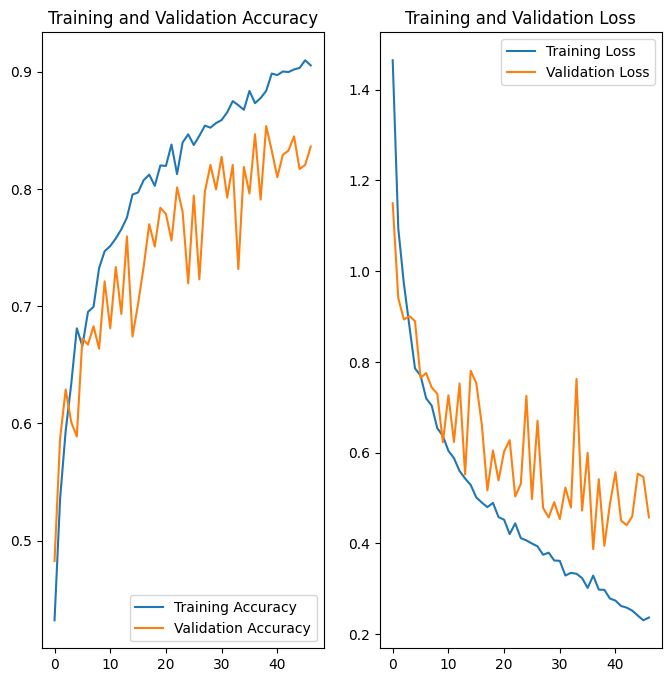

In [58]:
acc = augmented_model_progress.history['accuracy']
val_acc = augmented_model_progress.history['val_accuracy']

loss = augmented_model_progress.history['loss']
val_loss = augmented_model_progress.history['val_loss']

epochs_range = range(len(augmented_model_progress.history["loss"]))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig("/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/Augmented Model/Training and Validation Accuracy Loss/augmented_model_graph.png")
plt.show()

In [59]:
path = "/content/drive/MyDrive/brain_tumor_classification_dataset/brain_tumor_dataset/brain_tumor_classification/Testing/glioma_tumor/image(19).jpg"

img = tf.keras.utils.load_img(
    path, target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = augmented_model.predict(img_array)
score = tf.nn.softmax(predictions[0])



print(
    "First diagnostic scan indicates the presence of {} anomaly with a {:.2f}% probability."
    .format(class_names[tf.math.top_k(score, k=2).indices.numpy()[0]], 100 * tf.math.top_k(score, k=2).values.numpy()[0])
)

print(" ")

print(
    "The secondary outcome suggests {} anomaly with a {:.2f}% probability of occurrence."
    .format(class_names[tf.math.top_k(score, k=2).indices.numpy()[1]], 100 * tf.math.top_k(score, k=2).values.numpy()[1])
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
First diagnostic scan indicates the presence of no_tumor anomaly with a 47.24% probability.
 
The secondary outcome suggests meningioma_tumor anomaly with a 17.69% probability of occurrence.


Found 394 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


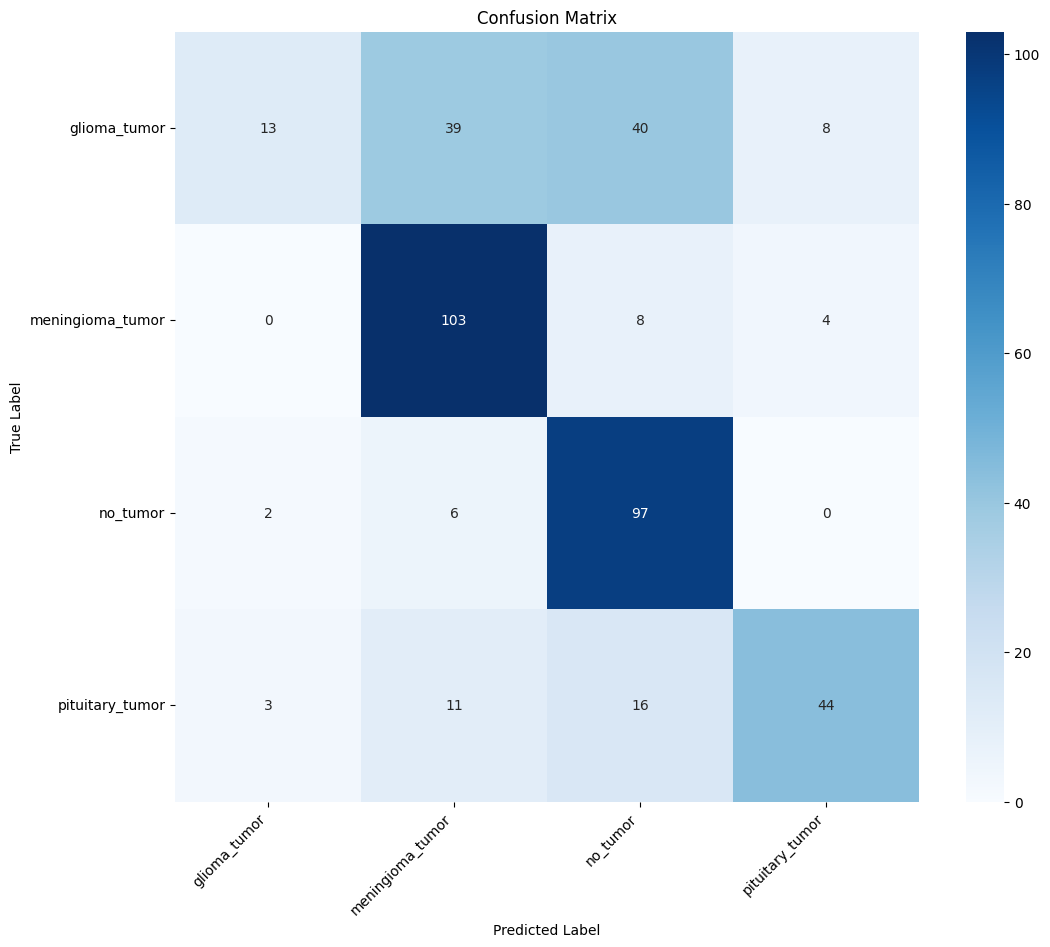

                  precision    recall  f1-score   support

    glioma_tumor       0.72      0.13      0.22       100
meningioma_tumor       0.65      0.90      0.75       115
        no_tumor       0.60      0.92      0.73       105
 pituitary_tumor       0.79      0.59      0.68        74

        accuracy                           0.65       394
       macro avg       0.69      0.64      0.59       394
    weighted avg       0.68      0.65      0.60       394



In [62]:
#Load the testing dataset
test_dataset_dir = "/content/drive/MyDrive/brain_tumor_classification_dataset/brain_tumor_dataset/brain_tumor_classification/Testing"
test_ds = tf.keras.utils.image_dataset_from_directory(test_dataset_dir, image_size=(image_height, image_width), batch_size=batch_size)

#Get the true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    predictions = augmented_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

#Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)

#Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.savefig("/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/Augmented Model/augmented_model_confusion_matrix.png")
plt.show()

report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)